<a href="https://colab.research.google.com/github/kumarmanishjha/pgm-prjoject_A18/blob/master/Vanilla_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
  
!pip install imageio  

tcmalloc: large alloc 1073750016 bytes == 0x57bda000 @  0x7f0f4edd12a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641
    100% |████████████████████████████████| 3.3MB 9.9MB/s 
  Running setup.py bdist_wheel for imageio ... - \ | / done
  Stored in directory: /root/.cache/pip/wheels/e0/43/31/605de9372ceaf657f152d3d5e82f42cf265d81db8bbe63cde1
Successfully built imageio


In [2]:
from google.colab import drive
drive.mount('/content/drive')

added_path = 'drive/My Drive/results/MNIST_GAN_results/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import os
import pickle
import random
import imageio
from torch.autograd import Variable
import itertools
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import time

Data set

In [0]:
# dataset

train_MNIST = True
train_CIFAR_10 = False


transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

if train_MNIST:
  train_data = datasets.MNIST('../data', train=True, 
                            download=True, transform=transform)
  
  image_size = 28
  n_channels = 1 
  # test_data = datasets.MNIST('../data', train=False, transform=transform)
  
elif train_CIFAR_10:
  # CIFAR 10 Data set !!
  train_data = datasets.CIFAR10(root='./data', train=True,
                              download=True, transform=transform)
  
  image_size = 32
  n_channels = 3 



using cuda !
n_data_total = 60000 ; n_train_images = 60000 ; n_valid = 0
This is the shape of one batch: torch.Size([128, 1, 28, 28])


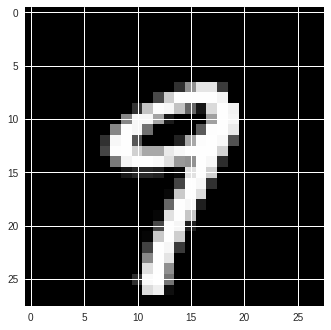

In [13]:
# This parameter influences optimization
batch_size = 128
# This is just for evaluation, we want is as big as the GPU can support
batch_size_eval = 512

# CPU or GPU
if torch.cuda.is_available():
    device = torch.device("cuda")
    use_cuda = True
    print('using cuda !')
else:
    device = torch.device("cpu")
    use_cuda = False
    
indices = list(range(len(train_data)))
random.shuffle(indices)

n_data_total = len(train_data)
n_valid = 0
n_train_images = n_data_total - n_valid
print('n_data_total =', n_data_total, '; n_train_images =', 
       n_train_images, '; n_valid =', n_valid)



# DataLoaders
train_loader = DataLoader(
    train_data,
    batch_size=batch_size,
    sampler=SubsetRandomSampler(indices[n_valid:]),
    #num_workers=1,
    pin_memory=use_cuda
)

#valid_loader = DataLoader(
#    train_data,
#    batch_size=batch_size_eval,
#    sampler=SubsetRandomSampler(indices[:n_valid]),
#    #num_workers=1,
#    pin_memory=use_cuda,
#)


# visualize and understand the data
for inputs, targets in train_loader:
    print("This is the shape of one batch:", inputs.shape)
    img = inputs[0, 0]
    img = img / 2 + 0.5     # unnormalize
    plt.imshow(img, cmap='Greys_r')
    break    

Samplers

In [18]:
def gaussian_noise_sampler(mu, sigma, device):
    """ Gaussian input to the generator"""
    return lambda m, n: torch.Tensor(np.random.normal(mu, sigma, (m, n))).to(device)


def uniform_noise_sampler(a, b, device):
    """ Uniform input to the generator of a m x n tensor"""
    return lambda m, n: (b - a) * torch.rand(m, n).to(device) + a
  
def plot_a_gen_sample(gen_sample):
    img = gen_sample.view(image_size, image_size)
    plt.imshow(img, cmap='Greys_r')  
    plt.show()

# We feed in the generator a noise input   
# Uniform sampler on [-1, 1]
g_noise_input_generator = uniform_noise_sampler(-1, 1, device)
# Input noise of size 100
dim_gen_input = 100 

fixed_noise = g_noise_input_generator(5 * 5, dim_gen_input)

def show_result(model_G, dim_gen_input, num_epoch,
                show = False, save = False, path = 'result.png', isFix=False):
    
    with torch.no_grad():
      
      random_noise = g_noise_input_generator(5 * 5, dim_gen_input)

      if isFix:
          test_images = model_G(fixed_noise)
      else:
          test_images = model_G(random_noise)

      size_figure_grid = 5
      fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(5, 5))
      for i, j in itertools.product(range(size_figure_grid), range(size_figure_grid)):
          ax[i, j].get_xaxis().set_visible(False)
          ax[i, j].get_yaxis().set_visible(False)

      for k in range(5*5):
          i = k // 5
          j = k % 5
          ax[i, j].cla()
          ax[i, j].imshow(test_images[k, :].cpu().data.view(image_size, image_size).numpy(), cmap='gray')

      label = 'Epoch {0}'.format(num_epoch)
      fig.text(0.5, 0.04, label, ha='center')
      plt.savefig(path)

      if show:
          plt.show()
      else:
          plt.close()
        
    
def show_train_hist(hist, show = False, save = False, path = 'Train_hist.png'):
    x = range(len(hist['D_losses']))

    y1 = hist['D_losses']
    y2 = hist['G_losses']

    plt.plot(x, y1, label='D_loss')
    plt.plot(x, y2, label='G_loss')

    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.legend(loc=4)
    plt.grid(True)
    plt.tight_layout()

    if save:
        plt.savefig(path)

    if show:
        plt.show()
    else:
        plt.close()   
  
print('ok')

ok


In [0]:
# Standard slope of the leak of LeakyReLU is 0.01, 0.2 recommended by DCGAN paper
# but 0.2 seems to work very badly on our 2d data sets
slope_leaky_relu = 0.2
# 'k' steps in the original GAN paper. Can put the discriminator on higher training freq than generator
d_steps = 1
g_steps = 1

class Generator(nn.Module):
  
    def __init__(self, dim_input, dim_output):
        super(Generator, self).__init__()
        # fc for fully connected layer
        self.fc1 = nn.Linear(dim_input, 256)
        self.fc2 = nn.Linear(256, 512)
        self.fc3 = nn.Linear(512, 1024)
        self.fc4 = nn.Linear(1024, dim_output)
        self.tanh = nn.Tanh()

    def forward(self, x):
        # From https://github.com/soumith/ganhacks,
        # use LeakyReLU to avoid sparse gradients
        x = x.view(x.size(0), -1) # flatten
        x = F.leaky_relu(self.fc1(x), negative_slope=slope_leaky_relu)
        x = F.leaky_relu(self.fc2(x), negative_slope=slope_leaky_relu)
        x = F.leaky_relu(self.fc3(x), negative_slope=slope_leaky_relu)
        x = self.tanh(self.fc4(x))
        return x


dim_images = int(image_size ** 2)

model_G = Generator(dim_gen_input, dim_images).to(device)


class Discriminator(nn.Module):
    def __init__(self, dim_input, output_size):
        super(Discriminator, self).__init__()
        # fc for fully connected layer
        self.fc1 = nn.Linear(dim_input, 1024)
        self.dropout_1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(1024, 512)
        self.dropout_2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(512, 256)
        self.dropout_3 = nn.Dropout(0.3)
        self.fc4 = nn.Linear(256, output_size)

    def forward(self, x):
        # From https://github.com/soumith/ganhacks,
        # use LeakyReLU to avoid sparse gradients
        x = x.view(x.size(0), -1) # flatten
        x = F.leaky_relu(self.fc1(x), negative_slope=slope_leaky_relu)
        x = self.dropout_1(x)
        x = F.leaky_relu(self.fc2(x), negative_slope=slope_leaky_relu)
        x = self.dropout_2(x)
        x = F.leaky_relu(self.fc3(x), negative_slope=slope_leaky_relu)
        x = self.dropout_3(x)
        # Training a standard binary classifier with a
        # sigmoid output (--> using Binary Cross Entropy Loss)
        return torch.sigmoid(self.fc4(x))


# Single dimension for 'real' vs. 'fake'
# We can change this if we want to use gans that also classify
d_output_size = 1

model_D = Discriminator(dim_images, d_output_size).to(device)


# Use same learning rates  for generator + discriminator
# Learning rates recommended by the DCGAN paper for Adam
learning_rate = 2e-4
# From https://github.com/soumith/ganhacks, use Adam Optimizer
d_optimizer = optim.Adam(model_D.parameters(), lr=learning_rate)
g_optimizer = optim.Adam(model_G.parameters(), lr=learning_rate)
# use binary cross entropy loss function
loss_fn = nn.BCELoss()

arr_gradient_D = []
arr_gradient_G = []
arr_means = []
arr_std_dev = []
# set to true or false to plot the mean and std_dev
plot_means_and_var = False

real_label = 1
fake_label = 0

# results save folder
if not os.path.isdir(added_path):
    os.mkdir(added_path)
if not os.path.isdir(added_path + 'Random_results'):
    os.mkdir(added_path + 'Random_results')
if not os.path.isdir(added_path + 'Fixed_results'):
    os.mkdir(added_path + 'Fixed_results')

train_hist = {}
train_hist['D_losses'] = []
train_hist['G_losses'] = []


def train(model_G, model_D, epoch):

    model_D.train()
    model_G.train()
    
    D_losses = []
    G_losses = []
    
    time_now = time.clock()

    for batch_idx, (inputs, target) in enumerate(train_loader):
        inputs, target = inputs.to(device), target.to(device)
          
        for d_index in range(d_steps):

            # (1) Update Discriminator : maximize log(D(x)) + log(1 - D(G(z)))
            
            # this is not necessarily equal to batch size !
            n_images = len(inputs)
            
            # Reset gradients
            model_D.zero_grad()

            # on real samples
            d_real_decision = model_D(inputs)

            # To compute BCE loss
            label = torch.full((n_images, 1), real_label, device=device)
            # D(x) should be 1 for real samples
            d_real_loss = loss_fn(d_real_decision, label)

            # on fake samples
            d_gen_input = g_noise_input_generator(n_images, dim_gen_input)
            d_fake_data = model_G(d_gen_input).detach()  # detach to avoid training G on these labels
            d_fake_decision = model_D(d_fake_data)
            # D(x) now wants to be as close as possible as fake label value
            f_label = torch.full((n_images, 1), fake_label, device=device)
            d_fake_loss = loss_fn(d_fake_decision, f_label)
            
            # Total loss
            d_train_loss = d_fake_loss + d_real_loss
            d_train_loss.backward()
            d_optimizer.step()  # Only optimizes D's parameters; changes based on stored gradients from backward()
            
            D_losses.append(d_train_loss.item())

            # Compute the norm of gradient
            total_norm = 0
            for p in model_D.parameters():
                norm = p.grad.data.norm(2)
                total_norm += norm.item() ** 2
            total_norm = np.sqrt(total_norm)
            arr_gradient_D.append(total_norm)

        for g_index in range(g_steps):

            # (2) Update G network: maximize log(D(G(z)))
            model_G.zero_grad()

            gen_input = g_noise_input_generator(n_images, dim_gen_input)
            gen_output = model_G(gen_input)
            d_fake_decision = model_D(gen_output)

            # The generator tries to get D(G(z)) near 1
            label = torch.full((n_images, 1), real_label, device=device)
            g_loss = loss_fn(d_fake_decision,  label)

            g_loss.backward()
            g_optimizer.step()
            
            G_losses.append(g_loss.item())

            # Compute norm of gradient
            total_norm = 0
            for p in model_G.parameters():
                norm = p.grad.data.norm(2)
                total_norm += norm.item() ** 2
            total_norm = np.sqrt(total_norm)
            arr_gradient_G.append(total_norm)

        if batch_idx % 50 == 0:            
            # Store mean/std_dev            
            if plot_means_and_var:
                # Can't call numpy() on Variable that requires grad. Use var.detach().numpy() instead.
                np_gen_output = gen_output.detach().numpy()
                mean = np.mean(np_gen_output)
                std_dev = np.std(np_gen_output)
                arr_means.append(mean)
                arr_std_dev.append(std_dev)
                print('mean = ', mean, ' std_dev = ', std_dev)
            
            print('\rTrain Epoch: {} [{}/{} ({:.0f}%)] Time per epoch: {:.2f}s\t Gen_Loss: {:.4f}; D_Real_Loss: {:.4f}; D_Fake_Loss: {:.4f}'
                  .format(epoch, batch_idx * len(inputs), n_train_images,
                          100. * batch_idx / len(train_loader), n_train_images / (50 * batch_size) * (time.clock() - time_now), 
                          d_real_loss.item(), d_fake_loss.item(), g_loss.item()),
                  end='')        
            time_now = time.clock()
                 
    return D_losses, G_losses


n_epochs = 100
for ep in range(n_epochs):
    D_losses, G_losses = train(model_G, model_D, ep)
    
    p = added_path + 'Random_results/MNIST_GAN_' + str(ep + 1) + '.png'
    fixed_p = added_path + 'Fixed_results/MNIST_GAN_' + str(ep + 1) + '.png'
    show_result(model_G, dim_gen_input, (ep + 1), save=True, path=p, isFix=False)
    show_result(model_G, dim_gen_input, (ep + 1), save=True, path=fixed_p, isFix=True)
    train_hist['D_losses'].append(torch.mean(torch.FloatTensor(D_losses)))
    train_hist['G_losses'].append(torch.mean(torch.FloatTensor(G_losses)))

    
print("Training finish!... save training results")
torch.save(model_G.state_dict(), added_path + "generator_param.pkl")
torch.save(model_D.state_dict(), added_path + "discriminator_param.pkl")
with open(added_path + 'train_hist.pkl', 'wb') as f:
    pickle.dump(train_hist, f)

show_train_hist(train_hist, save=True, path= added_path + 'MNIST_GAN_train_hist.png')



In [0]:
# Generate some animation..? (haven't used it)
images = []
for ep in range(n_epochs):
    img_name = added_path + 'Fixed_results/MNIST_GAN_' + str(ep + 1) + '.png'
    images.append(imageio.imread(img_name))
imageio.mimsave(added_path + 'generation_animation.gif', images, fps=5)

In [49]:
# Save 10k MNIST images to a folder if you haven't already done so
# This will allow FID comparing

def save_real_images_data_set(path):
  
  test_data = datasets.MNIST('../data', train=False, transform=transform)

  test_loader = DataLoader(
    test_data,
    batch_size=batch_size_eval,
    #num_workers=1,
    pin_memory=use_cuda,
  )

  time_now = time.clock() 
  n_test_data = len(test_data)

  i = 0
  for batch_idx, (inputs, target) in enumerate(test_loader):

    n_inputs = len(inputs)

    for j in range(n_inputs):
        torchvision.utils.save_image(inputs[j, :].view(image_size, image_size), 
                                     path + 'img_' + str(i) + '.png', normalize = True)    
        i += 1

    print('\r Real_Images_Saved [{}/{} ({:.0f}%)] Time estimated left: {:.2f}s'
            .format(i, n_test_data, 100 * i / n_test_data, 
                    ((n_test_data - i) / batch_size) * (time.clock() - time_now)),   
            end='')
    time_now = time.clock()            
   
  
path_real = added_path + 'real_samples/'    

if not os.path.isdir(path_real):
    os.mkdir(path_real)
    save_real_images_data_set(path_real)
else:
    # don't compute twice !!
    print('Real Samples folder is already there !')
 


Real Samples folder is already there !


In [0]:
# need to install this to save images via pytorch.. 
!pip install Pillow==4.0

In [40]:
# Generate 10k samples
# by 100 batches of 100
import torchvision.utils

path_gen = added_path + 'gen_samples/'
if not os.path.isdir(path_gen):
    os.mkdir(path_gen)
    

time_now = time.clock() 
for i in range(100):
  noise = g_noise_input_generator(100, dim_gen_input)
  gen_images = model_G(noise)

  for j in range(100):
      torchvision.utils.save_image(gen_images[j, :].view(image_size, image_size), 
                        path_gen + 'img_' + str(i*100 + j) + '.png', normalize = True)    
      
  print('\r Gen_Images_Saved [{}/{} ({:.0f}%)] Time estimated left: {:.2f}s'
        .format((i + 1) * 100, 10000, (i + 1) / 100, (99 - i) * (time.clock() - time_now)),   
         end='')
  time_now = time.clock()
          

     
  
              
    

 Images_Saved [10000/100000 (0%)] Time estimated left: 0.00s